In [75]:
# Import libraries
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

In [76]:
# Import preprocessing method
from preprocessing import preprocess

In [77]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 30
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [78]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [79]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [80]:
# Load in embeddings
embeddings = api.load("word2vec-google-news-300")

# Create embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [87]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=ENCODED_VECTOR_SIZE, weights=[embedding_matrix], input_length=ENCODED_VECTOR_SIZE, trainable=False),
    Dropout(0.5),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    MaxPooling1D(3),
    Conv1D(BATCH_SIZE, 3, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
initial_lr = 0.001
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=10000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 300, 300)          44484000  
                                                                 
 dropout_12 (Dropout)        (None, 300, 300)          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 298, 128)          115328    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 99, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 97, 128)           49280     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                   

In [88]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/30
106/106 [==============================] - 14s 130ms/step - loss: 2.7884 - accuracy: 0.1296 - val_loss: 2.2382 - val_accuracy: 0.3495
Epoch 2/30
106/106 [==============================] - 14s 130ms/step - loss: 2.0403 - accuracy: 0.3219 - val_loss: 1.5427 - val_accuracy: 0.5272
Epoch 3/30
106/106 [==============================] - 13s 122ms/step - loss: 1.6298 - accuracy: 0.4466 - val_loss: 1.2878 - val_accuracy: 0.5922
Epoch 4/30
106/106 [==============================] - 13s 122ms/step - loss: 1.4490 - accuracy: 0.5147 - val_loss: 1.1723 - val_accuracy: 0.6200
Epoch 5/30
106/106 [==============================] - 13s 123ms/step - loss: 1.3374 - accuracy: 0.5598 - val_loss: 1.0985 - val_accuracy: 0.6512
Epoch 6/30
106/106 [==============================] - 13s 123ms/step - loss: 1.2600 - accuracy: 0.5866 - val_loss: 1.0337 - val_accuracy: 0.6698
Epoch 7/30
106/106 [==============================] - 13s 123ms/step - loss: 1.1928 - accuracy: 0.6121 - val_loss: 1.0070 - val_ac

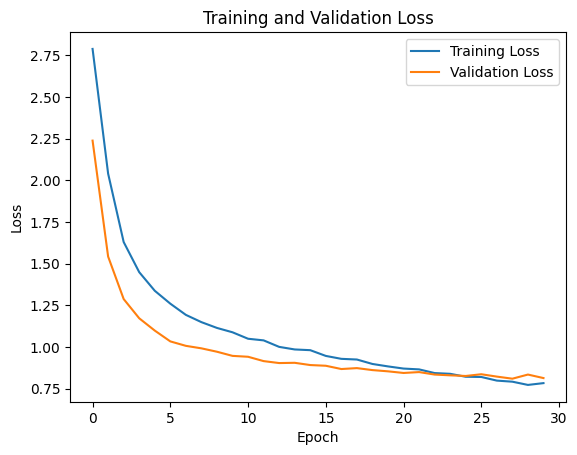

In [91]:
# Plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [92]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 1s 9ms/step
Accuracy: 0.7562334217506631
